# **Crypto assets market price and users behavior on Compound**
-  The main purpose of this notebook is to present a data exploratory visualization and see if there are some explicit correlation between market price of crypto assets & user behavior (with utilization_ratio as proxy)
-	Use Granger causality to test the lead/lag autocorrelation between two variables. Don't forget to check the model's assumption (e.g., stationary).
    - https://www.youtube.com/watch?v=XqsSB_vpHLs (Granger Causality)
    - https://www.youtube.com/watch?v=5jOW6baXYI4 (5 ways to fail with time series)
-	Check if the utilization ratio is correlated with the liquidity mining activities (use cETH to borrow ETH). Maybe we should find a way to remove self-borrowing from calculating the utilization ratio. (cf. daily liability matrix)


### Packages init

In [37]:
import altair as alt
import pandas as pd
import numpy as np

# Load data

market_price = pd.read_csv('../data/daily_markets.csv') # Load market price data
market_price = market_price[market_price['underlyingSymbol'].isin(['WBTC', 'ETH'])] # Filter out non-ETH/WBTC markets
print(market_price.columns) # Print columns
alt.data_transformers.enable('csv') # Enable csv data transformer

Index(['borrowRate', 'cash', 'collateralFactor', 'exchangeRate',
       'interestRateModelAddress', 'name', 'reserves', 'supplyRate', 'symbol',
       'cTokenAddress', 'totalBorrows', 'totalSupply', 'underlyingAddress',
       'underlyingName', 'underlyingPrice', 'underlyingSymbol',
       'accrualBlockNumber', 'blockTimestamp', 'borrowIndex', 'reserveFactor',
       'underlyingPriceUSD', 'underlyingDecimals', 'date', 'newPrice'],
      dtype='object')


DataTransformerRegistry.enable('csv')

### Plotting Data

### Price

In [38]:
# Plot market prices
prices = alt.Chart(market_price).mark_line().encode(
    x='date:T',
    y='underlyingPriceUSD:Q',
    color='underlyingSymbol:N',
)

prices

alt.Chart(...)

## Interest Rate

See https://altair-viz.github.io/gallery/select_detail.html to enhance rendering of plot

In [39]:
# Plot market borrow rates
interest_rate = alt.Chart(market_price).mark_line().encode(
    x='date:T',
    y='borrowRate:Q',
    color='underlyingSymbol:N',
)


## Utilization Ratio

In [40]:
market_price['utilization_ratio'] = market_price['totalBorrows'] / ( market_price['totalBorrows'] + market_price['cash'] - market_price['reserves'] )
print(market_price.columns)

u_ratio = alt.Chart(market_price).mark_line().encode(
    x='date:T',
    y='utilization_ratio:Q',
    color='underlyingSymbol:N',
)



u_ratio | interest_rate | prices

Index(['borrowRate', 'cash', 'collateralFactor', 'exchangeRate',
       'interestRateModelAddress', 'name', 'reserves', 'supplyRate', 'symbol',
       'cTokenAddress', 'totalBorrows', 'totalSupply', 'underlyingAddress',
       'underlyingName', 'underlyingPrice', 'underlyingSymbol',
       'accrualBlockNumber', 'blockTimestamp', 'borrowIndex', 'reserveFactor',
       'underlyingPriceUSD', 'underlyingDecimals', 'date', 'newPrice',
       'utilization_ratio'],
      dtype='object')


alt.HConcatChart(...)

## Log Return

In [41]:
import datetime
# Log return of crypto market prices
market_price['yield'] = market_price.groupby(['symbol', 'underlyingSymbol'])['underlyingPriceUSD'].apply(lambda x: np.log(x) - np.log(x.shift(1)))


# plot yield

yield_chart = alt.Chart(market_price).mark_line().encode(
    x='date:T',
    y='yield:Q',
    color='underlyingSymbol:N',
)

print(market_price.columns)
# Display prices | yield_chart | u_ratio  from 2020-01-01 to 2021-01-01

prices | yield_chart | u_ratio


Index(['borrowRate', 'cash', 'collateralFactor', 'exchangeRate',
       'interestRateModelAddress', 'name', 'reserves', 'supplyRate', 'symbol',
       'cTokenAddress', 'totalBorrows', 'totalSupply', 'underlyingAddress',
       'underlyingName', 'underlyingPrice', 'underlyingSymbol',
       'accrualBlockNumber', 'blockTimestamp', 'borrowIndex', 'reserveFactor',
       'underlyingPriceUSD', 'underlyingDecimals', 'date', 'newPrice',
       'utilization_ratio', 'yield'],
      dtype='object')


C:\Users\Bilal\AppData\Local\Temp\ipykernel_3120\975186037.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  market_price['yield'] = market_price.groupby(['symbol', 'underlyingSymbol'])['underlyingPriceUSD'].apply(lambda x: np.log(x) - np.log(x.shift(1)))


alt.HConcatChart(...)

In [42]:
#overlap WBTC yield and WBTC utilization ratio

wbtc = market_price[market_price['underlyingSymbol'] == 'WBTC']

wbtc_yield = alt.Chart(wbtc).mark_point(opacity=0.2, color='red').encode(
    x='date:T',
    y='yield:Q',

)

wbtc_utilization_ratio = alt.Chart(wbtc).mark_line(opacity=1, color='green').encode(
    x='date:T',
    y='utilization_ratio:Q',
)

wbtc_price = alt.Chart(wbtc).mark_line(interpolate="monotone").encode(
    x='date:T',
    y='underlyingPriceUSD:Q',
)


wbtc_yield + wbtc_utilization_ratio

alt.LayerChart(...)

In [43]:
wbtc_price & wbtc_utilization_ratio

alt.VConcatChart(...)

In [44]:
wbtc_yield.mark_bar() & wbtc_price

alt.VConcatChart(...)

## Max Yield

In [45]:
alt.Chart(wbtc).mark_rect().encode(
    alt.X("date(date):O").axis(labelAngle=0, format="%e").title("Day"),
    alt.Y("month(date):O").title("Month"),
    alt.Color("max(yield):Q").title("Yield"),
)

alt.Chart(...)

## Max Utilization Ratio

In [46]:
alt.Chart(wbtc).mark_rect().encode(
    alt.X("date(date):O").axis(labelAngle=0, format="%e").title("Day"),
    alt.Y("month(date):O").title("Month"),
    alt.Color("max(utilization_ratio):Q").title("Utilization Ratio"),
)

alt.Chart(...)

## Max Price

In [47]:
alt.Chart(wbtc).mark_rect().encode(
    alt.X("date(date):O").axis(labelAngle=0, format="%e").title("Day"),
    alt.Y("month(date):O").title("Month"),
    alt.Color("max(underlyingPriceUSD):Q").title("Price"),
)

alt.Chart(...)

In [75]:

# reindex market price with grouping by underlyingSymbol and sympol

wbtc.head()

,borrowRate,cash,collateralFactor,exchangeRate,interestRateModelAddress,name,reserves,supplyRate,symbol,cTokenAddress,...,accrualBlockNumber,blockTimestamp,borrowIndex,reserveFactor,underlyingPriceUSD,underlyingDecimals,date,newPrice,utilization_ratio,yield
425,0.021500,79.681813,0.0,0.02,0xbae04cbf96391086dc643e842b517734e214d698,Compound Wrapped BTC,0.000000,0.000097,cWBTC,0xc11b1268c1a384e55c48c2391d8d480264a3a7f4,...,8164922,1563321116,1.000026,100000000000000000,9572.296741,8,2019-07-16,NaN,0.005001,NaN
432,0.023160,92.630913,0.0,0.02,0xbae04cbf96391086dc643e842b517734e214d698,Compound Wrapped BTC,0.000013,0.000220,cWBTC,0xc11b1268c1a384e55c48c2391d8d480264a3a7f4,...,8171297,1563407535,1.000103,100000000000000000,9689.442386,8,2019-07-17,NaN,0.010532,0.012164
439,0.024264,97.212061,0.0,0.02,0xbae04cbf96391086dc643e842b517734e214d698,Compound Wrapped BTC,0.000024,0.000310,cWBTC,0xc11b1268c1a384e55c48c2391d8d480264a3a7f4,...,8177808,1563494324,1.000179,100000000000000000,10606.527453,8,2019-07-18,NaN,0.014213,0.090433
446,0.024310,97.720849,0.0,0.02,0xbae04cbf96391086dc643e842b517734e214d698,Compound Wrapped BTC,0.000033,0.000314,cWBTC,0xc11b1268c1a384e55c48c2391d8d480264a3a7f4,...,8183770,1563575298,1.000248,100000000000000000,10626.168168,8,2019-07-19,NaN,0.014368,0.001850
453,0.026043,98.238957,0.0,0.02,0xbae04cbf96391086dc643e842b517734e214d698,Compound Wrapped BTC,0.000048,0.000472,cWBTC,0xc11b1268c1a384e55c48c2391d8d480264a3a7f4,...,8190683,1563667173,1.000331,100000000000000000,10798.867281,8,2019-07-20,NaN,0.020145,0.016122


## **Investigating on potential correlation between coins market price and utilization_ratio**
- Time series analysis
    - Granger Causality
    - Time Lagged Cross Correlation
    - Dynamic Time Warping
    - Instantaneous phase synchrony
    - Fourier Transform
    - Power Spectrum Distribution
- Focus on Granger Causality
    - Computing the GC = log(V(e1)/V(e2)) on a **time-window** *(parameter s)* and the **model order** *(parameter k)* of the Autoregressive Model
        - Short **time-window** => worse model estimation but better temporal resolution
        - Long **time-window** => better model estimation but worse temporal resolution
        - Lower **order** => better model estimation (faster compuationt time) but less sensitive to history
        - Higher **order** => worse model estimation (longer compuationt time) but more sensitive to history
    - The MVGC multivariate Granger causality toolbox: a new approach to Granger-causal inference
        -The standard method of computing G-causality involves estimation of parameters for both a full and a nested (reduced) VAR model. The MVGC approach, by contrast, avoids explicit estimation of the reduced model, thus eliminating a source of estimation error and improving statistical power, and in addition facilitates fast and accurate estimation of the computationally awkward case of conditional G-causality in the frequency domain.

In [84]:
eth_utilization_ratio = alt.Chart(market_price[market_price['underlyingSymbol'] == 'ETH']).mark_line(opacity=1, color='green').encode( x='date:T', y='utilization_ratio:Q').properties(title=alt.Title(text='ETH Utilization Ratio'))
wtbc_utilization_ratio = alt.Chart(market_price[market_price['underlyingSymbol'] == 'WBTC']).mark_line(opacity=1, color='green').encode( x='date:T', y='utilization_ratio:Q').properties(title=alt.Title(text='WBTC Utilization Ratio'))
eth_price = alt.Chart(market_price[market_price['underlyingSymbol'] == 'ETH']).mark_line(interpolate="monotone").encode( x='date:T', y='underlyingPriceUSD:Q').properties(title=alt.Title(text='ETH Price'))
wbtc_price = alt.Chart(market_price[market_price['underlyingSymbol'] == 'WBTC']).mark_line(interpolate="monotone").encode( x='date:T', y='underlyingPriceUSD:Q').properties(title=alt.Title(text='WBTC Price'))

(eth_utilization_ratio | wtbc_utilization_ratio) & (eth_price | wbtc_price)

alt.VConcatChart(...)

 - Let's check granger causality between coin market price (wtbc or eth) and utilization ratio
 - https://youtu.be/4TkNZviNJC0 (Granger causality tests in python)

In [49]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
#build the time series, just a simple AR(1)
t1 = [0.1*np.random.normal()]
for _ in range(100):
    t1.append(0.5*t1[-1] + 0.1*np.random.normal())

In [51]:
#build the time series that is granger caused by t1
t2 = [item + 0.1*np.random.normal() for item in t1]
# adding a little bit of noise to t1 to make it more realistic

In [52]:
#adjust t1 and t2 creating a 3 day lag in t1
t1 = t1[3:]
t2 = t2[:-3]

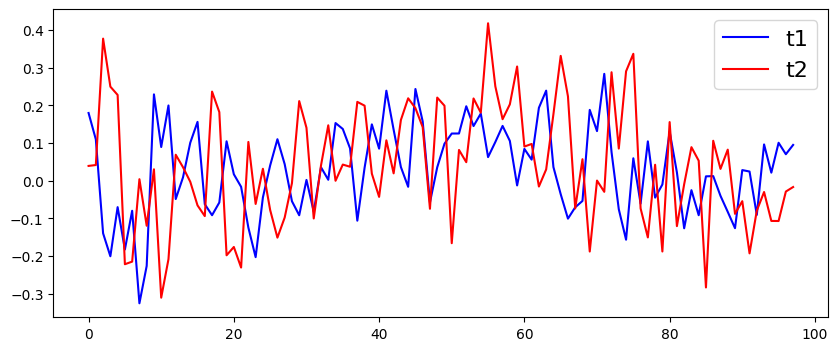

In [53]:
#plotting t1 and t2

plt.figure(figsize=(10,4))
plt.plot(t1, color='b')
plt.plot(t2, color='r')

plt.legend(['t1', 't2'], fontsize=16)

In [ ]:

ts_df = pd.DataFrame(columns=['t2', 't1'], data=zip(t2,t1))
ts_df.head()


In [ ]:
#testing if t2 granger causes t1 up to 5 lags

gc_results = grangercausalitytests(ts_df, 5)

- Clearly we see that reaching a GC 3-lag test leads us with p-value = 0.0 implying that 3 is the good order to explain t1 from t2

### Testing GC between market_price of wtbc and ETH and their respective utilization_ratio **without data cleaning** in a first time

In [ ]:

# granger causality test for wbtc underlyingPriceUSD on utilization_ratio

wbtc_ts_df = pd.DataFrame(columns=['underlyingPriceUSD', 'utilization_ratio'], data=zip(wbtc['underlyingPriceUSD'], wbtc['utilization_ratio']))
wbtc_ts_df.head()

In [115]:
#testing if underlyingPriceUSD granger causes utilization_ratio up to 5 lags
gc_results = grangercausalitytests(wbtc_ts_df, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1515  , p=0.6971  , df_denom=2337, df_num=1
ssr based chi2 test:   chi2=0.1517  , p=0.6969  , df=1
likelihood ratio test: chi2=0.1517  , p=0.6969  , df=1
parameter F test:         F=0.1515  , p=0.6971  , df_denom=2337, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1964  , p=0.8217  , df_denom=2334, df_num=2
ssr based chi2 test:   chi2=0.3936  , p=0.8214  , df=2
likelihood ratio test: chi2=0.3936  , p=0.8214  , df=2
parameter F test:         F=0.1964  , p=0.8217  , df_denom=2334, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2885  , p=0.8338  , df_denom=2331, df_num=3
ssr based chi2 test:   chi2=0.8680  , p=0.8331  , df=3
likelihood ratio test: chi2=0.8679  , p=0.8332  , df=3
parameter F test:         F=0.2885  , p=0.8338  , df_denom=2331, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2809  , p=0.

- Really bad result : the best p-value is 0.69 for a 1-lag assumption and increase to 1 with the order test.
- Let's do the same with eth price and its utilization ratio

In [116]:

# filtering for eth only

eth = market_price[market_price['underlyingSymbol'] == 'ETH']

eth.head()


,borrowRate,cash,collateralFactor,exchangeRate,interestRateModelAddress,name,reserves,supplyRate,symbol,cTokenAddress,...,accrualBlockNumber,blockTimestamp,borrowIndex,reserveFactor,underlyingPriceUSD,underlyingDecimals,date,newPrice,utilization_ratio,yield
2,0.012274,15.300218,0.75,0.020000,0xc64c4cba055efa614ce01f4bad8a9f519c4f8fab,Compound Ether,0.000005,0.000678,cETH,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,...,7716242,1557266749,1.000047,100000000000000000,171.043415,18,2019-05-07,NaN,0.061369,NaN
8,0.051584,25.900216,0.75,0.020001,0xc64c4cba055efa614ce01f4bad8a9f519c4f8fab,Compound Ether,0.000157,0.011974,cETH,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,...,7722478,1557351813,1.000220,100000000000000000,167.161458,18,2019-05-08,NaN,0.257919,-0.022957
14,0.045012,31.000212,0.75,0.020002,0xc64c4cba055efa614ce01f4bad8a9f519c4f8fab,Compound Ether,0.000290,0.009117,cETH,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,...,7728629,1557435375,1.000368,100000000000000000,165.824111,18,2019-05-09,NaN,0.225062,-0.008033
20,0.045012,31.000212,0.75,0.020002,0xc64c4cba055efa614ce01f4bad8a9f519c4f8fab,Compound Ether,0.000290,0.009117,cETH,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,...,7728629,1557435375,1.000368,100000000000000000,165.824111,18,2019-05-10,NaN,0.225062,0.000000
26,0.044995,31.024850,0.75,0.020003,0xc64c4cba055efa614ce01f4bad8a9f519c4f8fab,Compound Ether,0.000552,0.009110,cETH,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,...,7742225,1557618212,1.000659,100000000000000000,202.912497,18,2019-05-11,NaN,0.224976,0.201847


In [117]:
# granger causality test for eth underlyingPriceUSD on utilization_ratio

eth_ts_df = pd.DataFrame(columns=['underlyingPriceUSD', 'utilization_ratio'], data=zip(eth['underlyingPriceUSD'], eth['utilization_ratio']))
eth_ts_df.columns


Index(['underlyingPriceUSD', 'utilization_ratio'], dtype='object')

In [118]:

#testing if underlyingPriceUSD granger causes utilization_ratio up to 5 lags
gc_results = grangercausalitytests(eth_ts_df, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0166  , p=0.3135  , df_denom=1543, df_num=1
ssr based chi2 test:   chi2=1.0185  , p=0.3129  , df=1
likelihood ratio test: chi2=1.0182  , p=0.3129  , df=1
parameter F test:         F=1.0166  , p=0.3135  , df_denom=1543, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8929  , p=0.1510  , df_denom=1540, df_num=2
ssr based chi2 test:   chi2=3.7981  , p=0.1497  , df=2
likelihood ratio test: chi2=3.7934  , p=0.1501  , df=2
parameter F test:         F=1.8929  , p=0.1510  , df_denom=1540, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3628  , p=0.2525  , df_denom=1537, df_num=3
ssr based chi2 test:   chi2=4.1071  , p=0.2501  , df=3
likelihood ratio test: chi2=4.1016  , p=0.2507  , df=3
parameter F test:         F=1.3628  , p=0.2525  , df_denom=1537, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1402  , p=0.

- better results than WBTC GC test but still high for the p-value = 0.15 for 2 lag
### Let's try again  **with data cleaning** this time
- https://youtu.be/7_Js8h709Dw (Cleaning data for time-series)

Text(0.5, 1.0, 'Normalized ETH and WBTC Utilization Ratio')

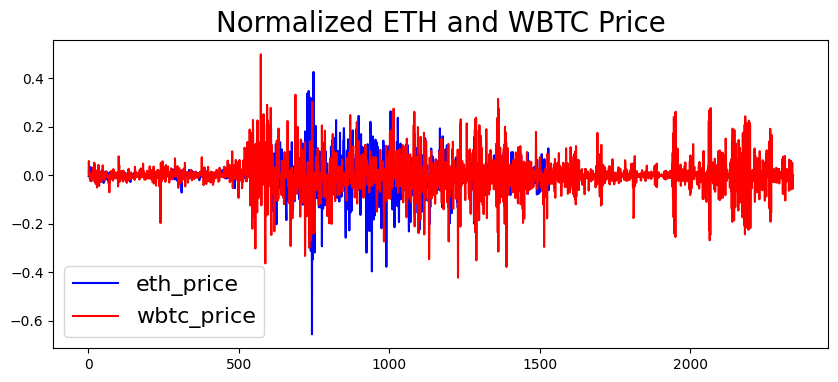

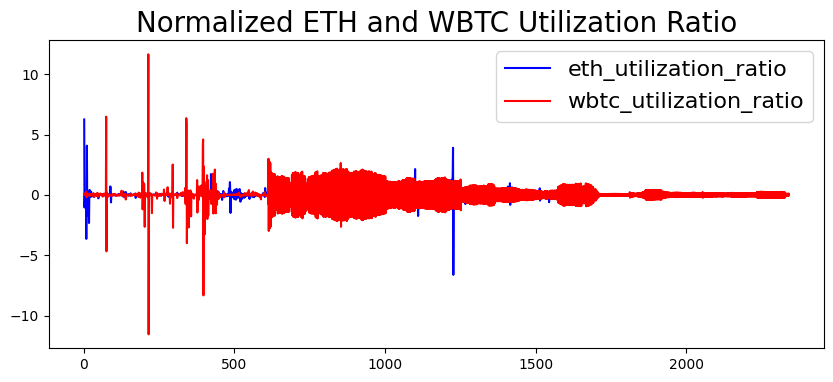

In [106]:
# normalize with pandas the data for eth and wbtc

eth_ts_df = (eth_ts_df - eth_ts_df.mean()) / eth_ts_df.std()
wbtc_ts_df = (wbtc_ts_df - wbtc_ts_df.mean()) / wbtc_ts_df.std()

# removing trend from the data (first property of a stationary time series)

eth_ts_df = eth_ts_df.diff().dropna()
wbtc_ts_df = wbtc_ts_df.diff().dropna()

# normalizing by a periodic, lets say 1 year, volatility (second property of a stationary time series)



#plotting eth_price and wbt_price

plt.figure(figsize=(10,4))
plt.plot(eth_ts_df['underlyingPriceUSD'], color='b')
plt.plot(wbtc_ts_df['underlyingPriceUSD'], color='r')

plt.legend(['eth_price', 'wbtc_price'], fontsize=16)
plt.title('Cleaned ETH and WBTC Price', fontsize=20)

#plotting eth_utilization_ratio and wbtc_utilization_ratio

plt.figure(figsize=(10,4))
plt.plot(eth_ts_df['utilization_ratio'], color='b')
plt.plot(wbtc_ts_df['utilization_ratio'], color='r')

plt.legend(['eth_utilization_ratio', 'wbtc_utilization_ratio'], fontsize=16)
plt.title('Cleaned ETH and WBTC Utilization Ratio', fontsize=20)


In [120]:
gc_results = grangercausalitytests(wbtc_ts_df, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1515  , p=0.6971  , df_denom=2337, df_num=1
ssr based chi2 test:   chi2=0.1517  , p=0.6969  , df=1
likelihood ratio test: chi2=0.1517  , p=0.6969  , df=1
parameter F test:         F=0.1515  , p=0.6971  , df_denom=2337, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1964  , p=0.8217  , df_denom=2334, df_num=2
ssr based chi2 test:   chi2=0.3936  , p=0.8214  , df=2
likelihood ratio test: chi2=0.3936  , p=0.8214  , df=2
parameter F test:         F=0.1964  , p=0.8217  , df_denom=2334, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2885  , p=0.8338  , df_denom=2331, df_num=3
ssr based chi2 test:   chi2=0.8680  , p=0.8331  , df=3
likelihood ratio test: chi2=0.8679  , p=0.8332  , df=3
parameter F test:         F=0.2885  , p=0.8338  , df_denom=2331, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2809  , p=0.